## R magic

In [ ]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Imports

In [ ]:
import json
import pandas as pd
import numpy as np
import random
from itertools import product
import sklearn
import math
import re
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
from rpy2.robjects import pandas2ri

## Loading events from 9 EE datasets

In [ ]:
file_names = ['cg_train_graphs.json']

In [ ]:
graphs = []

In [ ]:
DIR = "datasets_json/"
for fn in file_names:
  with open(DIR + fn) as ff:
    temp = [g for g in json.load(ff)]
    graphs.extend(temp)

## DataFrame construction and preview

Number of events for each dataset:
*   **cg** 4285

In [ ]:
df = pd.DataFrame(graphs)

## Event type retrieval

Note: in the case of nested events, we consider the trigger type of the main event (DAG root)

In [ ]:
# Obtain the root node of each graph
roots = [g[1]['root'] for g in df['graph'].items()]

In [ ]:
# Obtain a list with the information of each node in each graph
nodes_list = [n[1] for n in df['nodes'].items()]

In [ ]:
# For each event graph, we take the type information from the trigger node (id matching)
event_type = [n['type'] for i in range(len(graphs)) for n in nodes_list[i] if n['id'] == roots[i]] 

In [ ]:
df['event_type'] = event_type

##Node distribution

Number of event graph instances for each graph size class (i.e., number of nodes).

In [ ]:
lenghts = [len(nodes_list[i]) for i in range(len(df))]

In [ ]:
df['len'] = lenghts

In [ ]:
df['len'].value_counts()

2     1657
3     1048
4      736
5      410
6      210
7      100
8       59
9       37
10      13
11       9
13       4
15       1
12       1
Name: len, dtype: int64

### Introducing a range for event graph size

Starting from the event graph distribution for each graph size, a reasonable splitting on #nodes is 2, 3, 4, 5, 6, > 7.

In [ ]:
df['range_len'] = df['len'].copy()

In [ ]:
df['range_len'][df['len'] >= 7] = 7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df['range_len'] = [str(n) for n in df['range_len']]

In [ ]:
df['range_len'].value_counts()

2    1657
3    1048
4     736
5     410
7     224
6     210
Name: range_len, dtype: int64

###Instance-based event type filtering

## Stratified sampling with R

We remove unnecessary columns to speed-up the following operations.

In [ ]:
data = df.copy()

In [ ]:
data.drop(columns=['graph', 'nodes', 'len', 'links'], inplace=True)

In [ ]:
data.head()

,directed,multigraph,event_type,range_len
0,True,False,Positive_regulation,5
1,True,False,Positive_regulation,4
2,True,False,Positive_regulation,3
3,True,False,Development,2
4,True,False,Positive_regulation,2


In [ ]:
grouped_events = data.groupby(['event_type', 'range_len']).count()
grouped_events

directed  multigraph
event_type    range_len                      
Acetylation   2                 2           2
Binding       2                26          26
              3                37          37
              4                18          18
              5                 3           3
...                           ...         ...
Synthesis     2                14          14
              3                 2           2
Transcription 2                27          27
              3                 4           4
Translation   2                 5           5

[100 rows x 2 columns]

keep only event graphs whitin a class (i.e. event type, graph size) having at least 10 instances

In [ ]:
data = data.groupby(['event_type', 'range_len']).filter(lambda x : len(x) >= 10)

We install and load the "stratify" package.

In [ ]:
%%R
install.packages("splitstackshape")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/splitstackshape_1.4.8.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 33972 bytes (33 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


In [ ]:
%%R
library(splitstackshape)

In [ ]:
# - Grouping on dataset name, event type, and graph size range
# - Number of samples from each group = 20
%%R -i data
samples <- stratified(data, c('event_type', 'range_len'), 22, replace=FALSE, keep.rownames=TRUE)
print(nrow(samples))

R[write to console]: Groups Localization 4, Metabolism 2, Synthesis 2, Metastasis 3, Gene_expression 4, Mutation 4, Pathway 3, Remodeling 2, Binding 4 contain fewer rows than requested. Returning all rows.



[1] 1033


In [ ]:
s = %R samples

## Sampling post-processing and visualizations

In [ ]:
print(s)
# Note: 'rn' is the event graph id (i.e., row number on the dataset before sampling)

        rn  directed  multigraph           event_type range_len
1      140         1           0  Positive_regulation         5
2     3487         1           0  Positive_regulation         5
3      923         1           0  Positive_regulation         5
4      749         1           0  Positive_regulation         5
5     1757         1           0  Positive_regulation         5
...    ...       ...         ...                  ...       ...
1029   819         1           0              Binding         4
1030  3693         1           0              Binding         4
1031  3211         1           0              Binding         4
1032  1490         1           0              Binding         4
1033  1045         1           0              Binding         4

[1033 rows x 5 columns]


In [ ]:
s['rn'] = [int(n) for n in s['rn']]

In [ ]:
final = df.loc[list(s['rn']), :]

In [ ]:
final['event_type'].value_counts()

Positive_regulation         132
Negative_regulation         132
Regulation                  132
Planned_process              66
Localization                 62
Binding                      62
Mutation                     60
Gene_expression              54
Metastasis                   39
Pathway                      32
Carcinogenesis               22
Development                  22
Cell_proliferation           22
Breakdown                    22
Cell_differentiation         22
Blood_vessel_development     22
Death                        22
Growth                       22
Cell_transformation          22
Transcription                22
Metabolism                   16
Synthesis                    14
Remodeling                   12
Name: event_type, dtype: int64

In [ ]:
grouped_events = final.groupby(['event_type', 'range_len']).count()
grouped_events

directed  multigraph  ...  links  len
event_type               range_len                        ...            
Binding                  2                22          22  ...     22   22
                         3                22          22  ...     22   22
                         4                18          18  ...     18   18
Blood_vessel_development 2                22          22  ...     22   22
Breakdown                2                22          22  ...     22   22
Carcinogenesis           2                22          22  ...     22   22
Cell_differentiation     2                22          22  ...     22   22
Cell_proliferation       2                22          22  ...     22   22
Cell_transformation      2                22          22  ...     22   22
Death                    2                22          22  ...     22   22
Development              2                22          22  ...     22   22
Gene_expression          2                22          22  ...     22   22
                         3                22          22  ...     22   22
                         4                10          10  ...     10   10
Growth                   2                22          22  ...     22   22
Localization             2                22          22  ...     22   22
                         3                22          22  ...     22   22
                         4                18          18  ...     18   18
Metabolism               2                16          16  ...     16   16
Metastasis               2                22          22  ...     22   22
                         3                17          17  ...     17   17
Mutation                 2                22          22  ...     22   22
                         3                22          22  ...     22   22
                         4                16          16  ...     16   16
Negative_regulation      2                22          22  ...     22   22
                         3                22          22  ...     22   22
                         4                22          22  ...     22   22
                         5                22          22  ...     22   22
                         6                22          22  ...     22   22
                         7                22          22  ...     22   22
Pathway                  2                22          22  ...     22   22
                         3                10          10  ...     10   10
Planned_process          2                22          22  ...     22   22
                         3                22          22  ...     22   22
                         4                22          22  ...     22   22
Positive_regulation      2                22          22  ...     22   22
                         3                22          22  ...     22   22
                         4                22          22  ...     22   22
                         5                22          22  ...     22   22
                         6                22          22  ...     22   22
                         7                22          22  ...     22   22
Regulation               2                22          22  ...     22   22
                         3                22          22  ...     22   22
                         4                22          22  ...     22   22
                         5                22          22  ...     22   22
                         6                22          22  ...     22   22
                         7                22          22  ...     22   22
Remodeling               2                12          12  ...     12   12
Synthesis                2                14          14  ...     14   14
Transcription            2                22          22  ...     22   22

[50 rows x 6 columns]

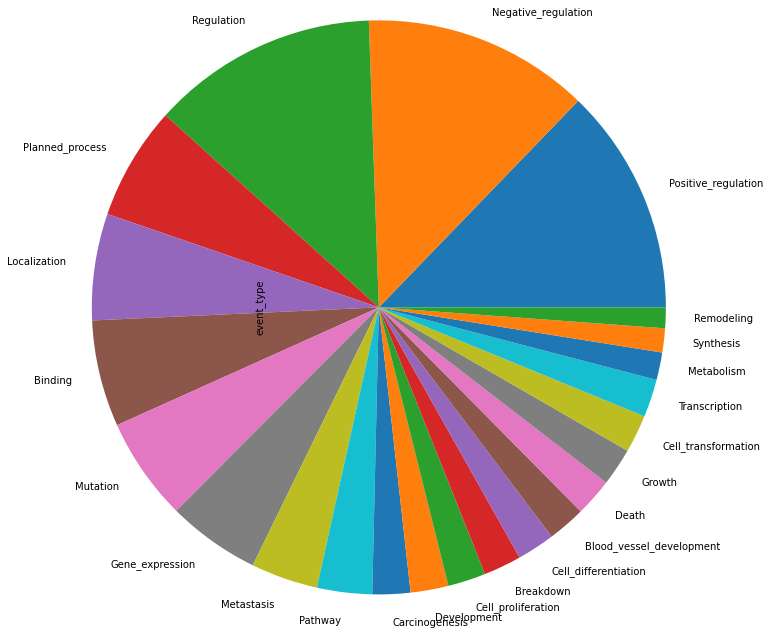

In [ ]:
final['event_type'].value_counts().plot.pie(radius=3.3)

## Writing sampled event graphs on a file

In [ ]:
r = final.copy()
r = r.drop(columns=['event_type', 'len', 'range_len'])
r = r.to_dict(orient='records')
with open(DIR + 'cg_stratified_sample.json', 'w') as outfile:
    json.dump(r, outfile)